# FLAX

## 상태(State)

일단 상태가 뭔지 이해해야합니다. 이전에 말했듯이 JAX의 기능을 완전히 사용하기 위해서는 결국 컴파일 가능한 순수함수의 형태로 코딩하는게 바람직합니다. 근데 신경망을 만들어서 학습하는걸 한번 생각해볼까요? 

신경망에 존재하는 파라미터는 계속 값이 변해야합니다. 근데 이게 값이 변하면 신경망의 feedforward 함수를 다시 컴파일 해야하는 것을 의미합니다.

이 문제를 해결하기 위해 FLAX는 상태(state)라는 개념을 도입합니다. 상태는 신경망의 파라미터와 같은 변하는 값을 담고 있는 컨테이너입니다. FLAX에서는 모델의 파라미터를 직접 변경하는 대신, 상태를 업데이트하는 방식을 사용합니다. 이 상태값은 "나중에 넣어줄 테니까 일단 여기에 뭔가 들어가있다고 가정한 상태로" 컴파일해놓기 때문에 컴파일된 함수를 재사용할 수 있습니다. 

다시말하자면 대충 공간뚫어놓고 이런 쉐잎의 이런 데이터타입의 어레이가 들어갈테니 연산만 연결해놓은 상태로 컴파일합니다. 

이런 방식은 새로운게 아닙니다. CUDA의 명령어를 직접 사용하지 않는 (c++을 사용하지 않는) 딥러닝 프레임워크는 얼마나 쓰기 간편하냐의 차이지 전부 이런 wrapper 형태를 사용합니다. 가장 원?시 적인 형태의 python 딥러닝 라이브러리인 tensorflow의 0.x 버전에서 사용하던 placeholder와 같습니다. 

예를 들어 tensorflow 0.x 버전에서는 다음과 같이 코딩했습니다.
```python
import tensorflow as tf

# 1. 껍데기(Graph) 만들기: "나중에 숫자를 줄 테니 자리를 비워둬라"
# FLAX에서 'State'나 'Params'가 들어갈 자리를 미리 가정하고 컴파일하는 것과 같습니다.
a = tf.placeholder(tf.float32)
b = tf.placeholder(tf.float32)

# 2. 로직 정의: "들어온 두 값을 더해라" (아직 계산은 안 함)
# FLAX의 모델 정의(feedforward) 부분에 해당합니다.
adder_node = a + b 

# 3. 실행 (Session): "자, 이제 실제 값을 줄게. 계산해!"
sess = tf.Session()

# sess.run을 할 때 feed_dict로 값을 '주입'합니다.
# 이것이 FLAX에서 model.apply({'params': params}, x) 처럼 
# 파라미터와 데이터를 외부에서 넣어주는 것과 완벽하게 대응됩니다.
result = sess.run(adder_node, feed_dict={a: 3, b: 4.5})

print(result) # 7.5
```

보시면 나중에 값을 넣어주고 실행시키면 그때 placeholder 에 값이 들어갑니다.

마찬가지로 FLAX에서도 봅시다. 이번엔 상태가 제대로 정의되지 않은 상태의 jit의 예시를 먼저 보자면

In [1]:
import jax
import jax.numpy as jnp


class Counter:
    """간단한 카운터."""


    def __init__(self):
        self.n = 0


    def count(self) -> int:
        """카운터함수로 값을 1추가하고 새로운 값으로 출력한다."""
        self.n += 1
        return self.n


    def reset(self):
        """0으로 리셋한다."""
        self.n = 0


counter = Counter()

counter.reset()
fast_count = jax.jit(counter.count)


for _ in range(3):
    print(fast_count())

1
1
1


이전의 내용에서 다뤘듯이 처음 컴파일된 형식 그대로 들어가기 떄문에 계속 1이 나오는걸 볼 수 있습니다. 다시 말해서 self.n이 처음 컴파일될때 0으로 고정되어버립니다.

따라서 다음과 같이하여 state를 관리합니다.

In [4]:
from typing import Tuple


CounterState = int


class CounterV2:


  def count(self, n: CounterState) -> Tuple[int, CounterState]:
    return n+1, n+1


  def reset(self) -> CounterState:
    return 0


counter = CounterV2()
state = counter.reset()


for _ in range(3):
  value, state = counter.count(state)
  print(value)
  

1
2
3


이렇게 그냥 돌렸을땐 당연히 잘되고 

In [5]:
state = counter.reset()
fast_count = jax.jit(counter.count)


for _ in range(3):
  value, state = fast_count(state)
  print(value)


1
2
3


state 를 입력으로 받아서 처리하도록 만들어져 있는 이 경우에도 우리가 생각한대로 업데이트하면서 잘 돌립니다. 여기서는 입력-출력을 state로 만들어서 컴파일되는 함수 자체에서 고정되는 값이 없습니다!

## FLAX로 신경망 만들기 (기초)

간단하게 말하자면, FLAX는 torch의 nn.Module 을 따라만들었다고 보시면 됩니다. torch의 numpy 같은 연산 부분은 JAX가 담당하고, nn.Module 과 비슷한 역할을 하는게 FLAX입니다. (이전에도 말했지만 optimizer 역할은 optax가 담당합니다.)



In [7]:
!pip install flax optax
!pip install datasets # 예제를 돌리기위해서

/home/hail/anaconda3/envs/dist/lib/python3.11/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


  Using cached dill-0.4.0-py3-none-any.whl.metadata (10 kB)
  Using cached httpx-0.28.1-py3-none-any.whl.metadata (7.1 kB)
  Using cached httpcore-1.0.9-py3-none-any.whl.metadata (21 kB)
  Using cached aiohappyeyeballs-2.6.1-py3-none-any.whl.metadata (5.9 kB)
  Using cached aiosignal-1.4.0-py3-none-any.whl.metadata (3.7 kB)
  Using cached attrs-25.4.0-py3-none-any.whl.metadata (10 kB)
Using cached dill-0.4.0-py3-none-any.whl (119 kB)
Using cached httpx-0.28.1-py3-none-any.whl (73 kB)
Using cached httpcore-1.0.9-py3-none-any.whl (78 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 57.5 MB/s  0:00:00
Using cached aiohappyeyeballs-2.6.1-py3-none-any.whl (15 kB)
Using cached aiosignal-1.4.0-py3-none-any.whl (7.5 kB)
Using cached attrs-25.4.0-py3-none-any.whl (67 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 MB 74.0 MB/s  0:00:00m0:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15/15 [datasets]/15 [datasets]ess]


일단 데이터로드하구요

In [4]:
import jax
import jax.numpy as jnp
import numpy as np
from datasets import load_dataset


def get_datasets():
    """MNIST 데이터셋 로드 및 전처리
    
    datasets 라이브러리의 최신 버전에서는 직접 인덱싱이 제대로 동작하지 않으므로
    먼저 numpy 배열로 변환한 후 JAX 배열로 변환합니다.
    """
    datasets = load_dataset("mnist")
    
    # numpy 배열로 먼저 변환 후 처리
    train_images = np.array(datasets["train"]["image"])
    train_labels = np.array(datasets["train"]["label"])
    test_images = np.array(datasets["test"]["image"])
    test_labels = np.array(datasets["test"]["label"])
    
    # 채널 차원 추가 및 정규화 후 JAX 배열로 변환
    datasets = {
        "train": {
            "image": jnp.array(train_images[..., None].astype(np.float32) / 255),
            "label": jnp.array(train_labels),
        },
        "test": {
            "image": jnp.array(test_images[..., None].astype(np.float32) / 255),
            "label": jnp.array(test_labels),
        },
    }
    return datasets['train'], datasets['test']

/home/hail/anaconda3/envs/dist/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
train_ds, test_ds = get_datasets()

### 모델 선언

이때 torch 스타일로 정의된 네트워크는 다음과 같습니다. 

In [6]:
from flax import linen as nn


class CNN(nn.Module):
    num_classes: int

    def setup(self):
        self.conv1 = nn.Conv(features=16, kernel_size=(5, 5), strides=(2, 2), padding='VALID')
        self.conv2 = nn.Conv(features=16, kernel_size=(5, 5), strides=(2, 2), padding='VALID')
        self.dense1 = nn.Dense(features=self.num_classes)

    def __call__(self, x,):
        x = self.conv1(x)
        x = nn.relu(x)
        x = self.conv2(x)
        x = nn.relu(x)
        x = jnp.mean(x, axis=(1, 2))
        x = self.dense1(x)
        return x

구조가 익숙하죠? torch.nn.Module 과 거의 동일합니다. 다만 forward 가 아닌 __call__ 메서드를 쓰고 __init__ 대신 setup 메서드를 사용한다는 점이 다릅니다.


여기서 features 는 output 채널 수입니다. Conv 레이어를 정의할때 input 채널 수는 따로 지정하지 않습니다. FLAX가 알아서 입력 데이터의 채널 수를 보고 맞춰줍니다.

참고로 padding='SAME' or 'VALID' 이건 tensorflow 에서 쓰던 방식입니다 ㅎ

이렇게 전체를 다 쓸수도 있지만 tensorflow 에서는 원래 레이어를 따로 정의하고 연산 연결하는 torch 스타일로 코딩을 안했거든요? jax도 마찬가지로 레이어를 정의하면서 연산을 정의하는 형태로 한번에 쓰는 방법이 있습니다. 만약 legacy tensorflow 스타일이 더 익숙하다면 이런 방식을 쓰기도 합니다. 이런 스타일을 compact 스타일이라고 합니다.

In [7]:
from flax import linen as nn


class CNN(nn.Module):
   num_classes: int


   @nn.compact
   def __call__(self, x,):
       x = nn.Conv(features=16, kernel_size=(5, 5), strides=(2, 2), padding='VALID')(x)
       x = nn.relu(x)
       x = nn.Conv(features=32, kernel_size=(5, 5), strides=(2, 2), padding='VALID')(x)
       x = nn.relu(x)
       x = jnp.mean(x, axis=(1, 2))
       x = nn.Dense(features=self.num_classes)(x)
       return x

torch 에서는 네트워크를 선언하면 알아서 initialize 되지만, flax는 따로 초기화 과정을 거쳐야합니다. 이렇게 파라미터를 별도로 초기화해주지 않고 미리 클래스내에서 정의하면 여러번 말했듯 컴파일된 함수내에 고정되어버리기 때문입니다. '상태' 의 형태로 별도로 만들어서 넣고 관리해줘야합니다. 

In [8]:
rng = jax.random.PRNGKey(0)
model = CNN(num_classes=10)
rng, key = jax.random.split(rng)
variables = model.init(key, jnp.ones((1, 28, 28, 1)))
params = variables['params']

flax 의 nn.Module 에는 init 메서드를 통해서 key를 넣어주고 가상의 입력 데이터를 넣어주면 내부적으로 파라미터를 초기화해줍니다. 여기서는 1로 가득찬 bs=1, 28x28x1 크기의 데이터를 넣어주었습니다.

그리고 다음과 같이 tabulate 메서드를 통해서 모델의 구조를 시각화할수 있습니다

In [9]:
print(model.tabulate(key, jnp.ones((1, 28, 28, 1))))


                                  CNN Summary                                   
┏━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ path    ┃ module ┃ inputs            ┃ outputs           ┃ params            ┃
┡━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│         │ CNN    │ float32[1,28,28,… │ float32[1,10]     │                   │
├─────────┼────────┼───────────────────┼───────────────────┼───────────────────┤
│ Conv_0  │ Conv   │ float32[1,28,28,… │ float32[1,12,12,… │ bias: float32[16] │
│         │        │                   │                   │ kernel:           │
│         │        │                   │                   │ float32[5,5,1,16] │
│         │        │                   │                   │                   │
│         │        │                   │                   │ 416 (1.7 KB)      │
├─────────┼────────┼───────────────────┼───────────────────┼───────────────────┤
│ Conv_1  │ Conv   │ float3

### loss 함수 및 optimizer 정의

모델을 선언했으면 다음은 gradient 를 흘려주기 위해서 loss 함수와 acc 와 같은 metric들을 정의해주는 함수를 만들어야합니다. 이는 대부분 optax와 flax의 기능을 사용해서 구현됩니다.

In [11]:
import optax

def compute_metrics(logits, labels):
    loss = jnp.mean(optax.softmax_cross_entropy(logits,
                    jax.nn.one_hot(labels, num_classes=10)))
    accuracy = jnp.mean(jnp.argmax(logits, -1) == labels)
    metrics = {
        'loss': loss,
        'accuracy': accuracy
    }
    return metrics

이 함수를 사용해서 jit 컴파일된 train_step 함수를 별도로 만들어서 사용하는게 JAX/FLAX의 일반적인 스타일입니다.

그 전에, parameter 를 넣어주고 업데이트 시켜서 다시 반영하기 위해서 위에서 초기했던 파라미터를 '상태' 로 만들어 줘야하는데, 이를 위해서 flax에서는 train_state라는 클래스를 제공합니다.

In [12]:
from flax.training.train_state import TrainState


learning_rate = 0.001
tx = optax.adam(learning_rate=learning_rate)


state = TrainState.create(
    apply_fn=model.apply,
    params=params,
    tx=tx,
)

여기서 tx는 optimizer 객체로 아시다시피 optimizer 도 단순하게 함수가 아니라 상태를 가지고 있어서 변하는 경우가 있습니다. 그래서 이 녀석도 같이 상태로 관리해줄 수 있습니다.

apply_fn 메서드는 모델의 __call__ 연산을 수행하는 함수입니다. 여기에 파라미터와 입력 데이터를 넣어주면 예측값이 나옵니다.

### jit 컴파일된 학습코드 

그 다음 jit 컴파일을 하기 위해서는 이렇게 정의된 state를 건네주고 건네받는, jit으로 가속할 부분만 뽑아서 함수로 묶어야합니다.

In [13]:
@jax.jit
def train_step(state, batch):
    def loss_fn(params):
        logits = state.apply_fn({'params': params}, batch['image'])
        loss = jnp.mean(optax.softmax_cross_entropy(
            logits=logits,
            labels=jax.nn.one_hot(batch['label'], num_classes=10))
        )
        return loss, logits
    grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
    (_, logits), grads = grad_fn(state.params)
    state = state.apply_gradients(grads=grads)


    metrics = compute_metrics(logits, batch['label'])
    return state, metrics



원래 torch 에서 loss.backward() 하고 optimizer.step() 하던 부분은 컨벤션으로 쓰이죠. 여기서도 다음 세줄이 컨벤션으로 쓰입니다.
```python

    grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
    (_, logits), grads = grad_fn(state.params)
    state = state.apply_gradients(grads=grads)

```

그리고 epoch 만큼 돌리는 메인 training 함수에서 이 jit 컴파일된 train_step 함수를 호출해주면 됩니다.

In [14]:
def train_loop(state, train_ds, batch_size, epoch, rng):
    train_ds_size = len(train_ds['image'])
    steps_per_epoch = train_ds_size // batch_size


    perms = jax.random.permutation(rng, train_ds_size)
    perms = perms[:steps_per_epoch * batch_size]  # Skip an incomplete batch
    perms = perms.reshape((steps_per_epoch, batch_size))

    batch_metrics = []
    for perm in perms:
        batch = {k: v[perm, ...] for k, v in train_ds.items()}
        state, metrics = train_step(state, batch)
        batch_metrics.append(metrics)


    training_batch_metrics = jax.device_get(batch_metrics)
    training_epoch_metrics = {
        k: sum([metrics[k] for metrics in training_batch_metrics])/steps_per_epoch
        for k in training_batch_metrics[0]}


    print('EPOCH: %d\nTraining loss: %.4f, accuracy: %.2f' % (epoch, training_epoch_metrics['loss'], training_epoch_metrics['accuracy'] * 100))
    return state


여기서 rng는 들어온 데이터 배치를 뒤섞는데 쓰였습니다. 

evaluation 을 하도록 만드는 것 역시도 jit 으로 컴파일한 eval함수를 만들어야합니다.

In [17]:
@jax.jit
def eval_step(state, batch):
    logits = state.apply_fn({'params': state.params}, batch['image'])
    return compute_metrics(logits, batch['label'])

def eval_loop(state, test_ds, batch_size):
    eval_ds_size = test_ds['image'].shape[0]
    steps_per_epoch = eval_ds_size // batch_size


    batch_metrics = []
    for i in range(steps_per_epoch):
        batch = {k: v[i*batch_size:(i+1)*batch_size, ...] for k, v in test_ds.items()}
        metrics = eval_step(state, batch)
        batch_metrics.append(metrics)


    eval_batch_metrics = jax.device_get(batch_metrics)
    eval_batch_metrics = {
        k: sum([metrics[k] for metrics in eval_batch_metrics])/steps_per_epoch
        for k in eval_batch_metrics[0]}
    print('    Eval loss: %.4f, accuracy: %.2f' % (eval_batch_metrics['loss'], eval_batch_metrics['accuracy'] * 100))


최종적으로 전체 학습코드 결과는 이렇게 됩니다.

In [18]:
train_epoch = 10
batch_size = 64
eval_batch_size = 100

for epoch in range(train_epoch):
    rng, key = jax.random.split(rng)
    state = train_loop(state, train_ds, batch_size, epoch, rng)
    eval_loop(state, test_ds, eval_batch_size)

EPOCH: 0
Training loss: 0.3318, accuracy: 90.51
    Eval loss: 0.2480, accuracy: 92.96
EPOCH: 1
Training loss: 0.2440, accuracy: 93.00
    Eval loss: 0.2045, accuracy: 93.68
EPOCH: 2
Training loss: 0.2029, accuracy: 94.08
    Eval loss: 0.1696, accuracy: 95.13
EPOCH: 3
Training loss: 0.1776, accuracy: 94.74
    Eval loss: 0.1602, accuracy: 95.60
EPOCH: 4
Training loss: 0.1604, accuracy: 95.27
    Eval loss: 0.1302, accuracy: 96.12
EPOCH: 5
Training loss: 0.1438, accuracy: 95.69
    Eval loss: 0.1380, accuracy: 95.75
EPOCH: 6
Training loss: 0.1331, accuracy: 96.09
    Eval loss: 0.1283, accuracy: 96.27
EPOCH: 7
Training loss: 0.1233, accuracy: 96.28
    Eval loss: 0.1061, accuracy: 96.90
EPOCH: 8
Training loss: 0.1165, accuracy: 96.52
    Eval loss: 0.1002, accuracy: 97.02
EPOCH: 9
Training loss: 0.1097, accuracy: 96.70
    Eval loss: 0.0984, accuracy: 97.03


매번 rng를 스플릿해서 새로운 rng를 만들어서 넣어주기 때문에 매 epoch 마다 데이터가 섞이며 컴파일된 함수임에도 불구하고 매 epoch 마다 다르게 섞인 배치가 들어갑니다.

인퍼런스'만'하고싶다면 다음과 같은 함수를 추가로 정의해서 돌리면됩니다.

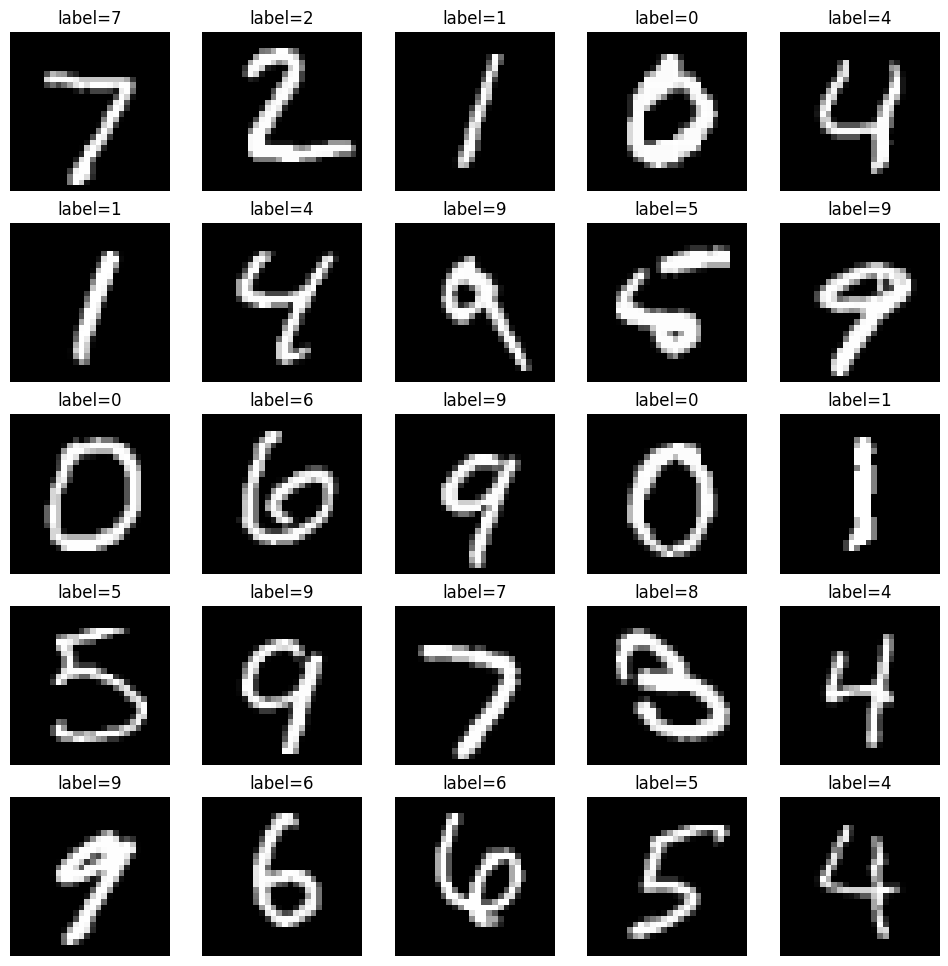

In [19]:
@jax.jit
def pred_step(state, batch):
    logits = state.apply_fn({'params': state.params}, batch)
    return logits.argmax(axis=1)

pred = pred_step(state, test_ds['image'][:25])

import matplotlib.pyplot as plt

fig, axs = plt.subplots(5, 5, figsize=(12, 12))
for i, ax in enumerate(axs.flatten()):
   ax.imshow(test_ds['image'][i], cmap='gray')
   ax.set_title(f"label={pred[i]}")
   ax.axis('off')

## 더 복잡한 방법들

### 배치 정규화

배치 정규화도 학습파라미터가 있다는 점을 감안하면 state 에 넣어서 관리해야합니다. 근데 한가지가 더있는데 inference할때 배치 정규화는 학습할때와 다르게 동작해야합니다. 그래서 배치 정규화 레이어는 학습모드와 평가모드를 구분하는 플래그가 필요합니다. 이 플래그 역시도 상태로 관리해야합니다.

In [ ]:
import flax.linen as nn

class CNN(nn.Module):
  num_classes: int


  @nn.compact
  def __call__(self, x, train: bool):
      x = nn.Conv(features=16, kernel_size=(5, 5), strides=(2, 2),
                  padding='VALID')(x)
      x = nn.BatchNorm(use_running_average=not train)(x)
      x = nn.relu(x)
      x = nn.Conv(features=32, kernel_size=(5, 5), strides=(2, 2),
                  padding='VALID')(x)
      x = nn.BatchNorm(use_running_average=not train)(x)
      x = nn.relu(x)
      x = jnp.mean(x, axis=(1, 2))
      x = nn.Dense(features=self.num_classes)(x)
      return x


In [ ]:
rng = jax.random.PRNGKey(0)
model = CNN(num_classes=10)


rng, key = jax.random.split(rng)
variables = model.init(key, jnp.ones((1, 28, 28, 1)), train=False)
params = variables['params']
batch_stats = variables['batch_stats']

In [ ]:
jax.tree_util.tree_map(jnp.shape, variables)

In [ ]:
def compute_metrics(logits, labels):
  loss = jnp.mean(optax.softmax_cross_entropy(logits, jax.nn.one_hot(labels, num_classes=10)))
  accuracy = jnp.mean(jnp.argmax(logits, -1) == labels)
  metrics = {
    'loss': loss,
    'accuracy': accuracy
  }
  return metrics


In [ ]:
from flax.training import train_state
from typing import Any

class TrainState(train_state.TrainState):
    batch_stats: Any


learning_rate = 0.001
tx = optax.adam(learning_rate=learning_rate)


state = TrainState.create(
    apply_fn=model.apply,
    params=params,
    batch_stats=batch_stats,
    tx=tx,
)


In [ ]:
@jax.jit
def train_step(state, batch):
  def loss_fn(params):
      logits, updates = state.apply_fn(
           {'params': params, 'batch_stats': state.batch_stats},
           batch['image'], train=True, mutable=['batch_stats'])
      loss = jnp.mean(optax.softmax_cross_entropy(
          logits=logits,
          labels=jax.nn.one_hot(batch['label'], num_classes=10))
      )
      return loss, (logits, updates)
  grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
  (_, (logits, updates)), grads = grad_fn(state.params)
  state = state.apply_gradients(grads=grads)
  state = state.replace(batch_stats=updates['batch_stats'])


  metrics = compute_metrics(logits, batch['label'])
  return state, metrics

def train_loop(state, train_ds, batch_size, epoch, rng):
  train_ds_size = len(train_ds['image'])
  steps_per_epoch = train_ds_size // batch_size

  perms = jax.random.permutation(rng, train_ds_size)
  perms = perms[:steps_per_epoch * batch_size]  # 완성되지 않은 배치는 생략합니다.
  perms = perms.reshape((steps_per_epoch, batch_size))

  batch_metrics = []
  for perm in perms:
    batch = {k: v[perm, ...] for k, v in train_ds.items()}
    state, metrics = train_step(state, batch)
    batch_metrics.append(metrics)


  training_batch_metrics = jax.device_get(batch_metrics)
  training_epoch_metrics = {
    k: sum([metrics[k] for metrics in training_batch_metrics])/steps_per_epoch
    for k in training_batch_metrics[0]}

  print('EPOCH: %d\nTraining loss: %.4f, accuracy: %.2f' % (epoch, training_epoch_metrics['loss'], training_epoch_metrics['accuracy'] * 100))
  return state



In [ ]:
@jax.jit
def eval_step(state, batch):
  logits = state.apply_fn(
     {'params': state.params, 'batch_stats': state.batch_stats},
     batch['image'], train=False)
  return compute_metrics(logits, batch['label'])

def eval_loop(state, test_ds, batch_size):
  eval_ds_size = test_ds['image'].shape[0]
  steps_per_epoch = eval_ds_size // batch_size
  batch_metrics = []
  for i in range(steps_per_epoch):
    batch = {k: v[i*batch_size:(i+1)*batch_size, ...] for k, v in test_ds.items()}
    metrics = eval_step(state, batch)
    batch_metrics.append(metrics)
  eval_batch_metrics = jax.device_get(batch_metrics)
  eval_batch_metrics = {
    k: sum([metrics[k] for metrics in eval_batch_metrics])/steps_per_epoch
    for k in eval_batch_metrics[0]}

  print('    Eval loss: %.4f, accuracy: %.2f' % (eval_batch_metrics['loss'], eval_batch_metrics['accuracy'] * 100))

In [ ]:
train_epoch = 10
batch_size = 64
eval_batch_size = 100
for epoch in range(train_epoch):
  rng, key = jax.random.split(rng)
  state = train_loop(state, train_ds, batch_size, epoch, rng)
  eval_loop(state, test_ds, eval_batch_size)


### 드롭아웃

드롭아웃도 inference할때는 적용되지 않아야합니다. 그래서 드롭아웃 레이어 역시도 학습모드와 평가모드를 구분하는 플래그가 필요합니다. 이 플래그 역시도 상태로 관리해야합니다.

In [ ]:
class CNN(nn.Module):
    num_classes: int


    @nn.compact
    def __call__(self, x, train: bool):
        x = nn.Conv(features=16, kernel_size=(5, 5), strides=(2, 2),
                    padding='VALID')(x)
        x = nn.BatchNorm(use_running_average=not train)(x)
        x = nn.relu(x)
        x = nn.Conv(features=32, kernel_size=(5, 5), strides=(2, 2),
                    padding='VALID')(x)
        x = nn.BatchNorm(use_running_average=not train)(x)
        x = nn.relu(x)
        x = nn.Dropout(rate=0.5, deterministic=not train)(x)
        x = jnp.mean(x, axis=(1, 2))
        x = nn.Dense(features=self.num_classes)(x)
        return x


In [ ]:
rng = jax.random.PRNGKey(0)
model = CNN(num_classes=10)
main_key, params_key, dropout_key = jax.random.split(key=rng, num=3)
variables = model.init(params_key, jnp.ones((1, 28, 28, 1)),train=False)
params = variables['params']
batch_stats = variables['batch_stats']

jax.tree_util.tree_map(jnp.shape, variables)

In [ ]:
from flax.training import train_state
from typing import Any

class TrainState(train_state.TrainState):
  batch_stats: Any
  key: jax.random.key
learning_rate = 0.001
tx = optax.adam(learning_rate=learning_rate)
state = TrainState.create(
  apply_fn=model.apply,
  params=params,
  batch_stats=batch_stats,
  key=dropout_key,
  tx=tx,
  )


한 가지 주의할점은 dropout 이 랜덤프로세스이기 때문에 key를 넣어줘야한다는 점입니다!

In [ ]:
@jax.jit
def train_step(state, batch):
  dropout_train_key = jax.random.fold_in(key=dropout_key, data=state.step)
  def loss_fn(params):
    logits, updates = state.apply_fn(
      {'params': params, 'batch_stats': state.batch_stats},
      batch['image'], train=True, mutable=['batch_stats'],
      rngs={'dropout': dropout_train_key})
    loss = jnp.mean(optax.softmax_cross_entropy(
      logits=logits,
      labels=jax.nn.one_hot(batch['label'],
      num_classes=10)))
    return loss, (logits, updates)

  grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
  (_, (logits, updates)), grads = grad_fn(state.params)
  state = state.apply_gradients(grads=grads)
  state = state.replace(batch_stats=updates['batch_stats'])
  metrics = compute_metrics(logits, batch['label'])
  return state, metrics

앞서 말했듯 state.apply_fn이 결국 모델함수돌리는 부분이기 때문에 이부분만 보면됩니다.
```python
    logits, updates = state.apply_fn(
      {'params': params, 'batch_stats': state.batch_stats},
      batch['image'], train=True, mutable=['batch_stats'],
      rngs={'dropout': dropout_train_key})
```

### lr 스케쥴링 및 모델 저장 (checkpointing)

lr 스케쥴링에서는 오버핏하지 않는 모델을 저장하는 것을 목적으로 한다고 가정합시다. 이때는 우리 2가지를 알아야합니다. lr 스케쥴링은 누가봐도 state로 관리해야하는 개념에 lr 도 포함되게 구현하면될거고, checkpointing (모델의 중간단계를 저장하는거) 은 다른 라이브러리를 사용합니다.


In [44]:
!pip install orbax-checkpoint

/home/hail/anaconda3/envs/dist/lib/python3.11/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [45]:
class CNN(nn.Module):
    num_classes: int


    @nn.compact
    def __call__(self, x, train: bool):
        x = nn.Conv(features=16, kernel_size=(5, 5), strides=(2, 2),
                    padding='VALID')(x)
        x = nn.BatchNorm(use_running_average=not train)(x)
        x = nn.relu(x)
        x = nn.Conv(features=32, kernel_size=(5, 5), strides=(2, 2),
                    padding='VALID')(x)
        x = nn.BatchNorm(use_running_average=not train)(x)
        x = nn.relu(x)
        x = nn.Dropout(rate=0.5, deterministic=not train)(x)
        x = jnp.mean(x, axis=(1, 2))
        x = nn.Dense(features=self.num_classes)(x)
        return x


In [46]:
rng = jax.random.PRNGKey(0)
model = CNN(num_classes=10)
main_key, params_key, dropout_key = jax.random.split(key=rng, num=3)
variables = model.init(params_key, jnp.ones((1, 28, 28, 1)),train=False)
params = variables['params']
batch_stats = variables['batch_stats']

In [47]:
jax.tree_util.tree_map(jnp.shape, variables)

{'batch_stats': {'BatchNorm_0': {'mean': (16,), 'var': (16,)},
  'BatchNorm_1': {'mean': (32,), 'var': (32,)}},
 'params': {'BatchNorm_0': {'bias': (16,), 'scale': (16,)},
  'BatchNorm_1': {'bias': (32,), 'scale': (32,)},
  'Conv_0': {'bias': (16,), 'kernel': (5, 5, 1, 16)},
  'Conv_1': {'bias': (32,), 'kernel': (5, 5, 16, 32)},
  'Dense_0': {'bias': (10,), 'kernel': (32, 10)}}}

In [48]:
def compute_metrics(logits, labels):
  loss = jnp.mean(optax.softmax_cross_entropy(logits, jax.nn.one_hot(labels, num_classes=10)))
  accuracy = jnp.mean(jnp.argmax(logits, -1) == labels)
  metrics = {
    'loss': loss,
    'accuracy': accuracy
  }
  return metrics

그런데 flax가 디폴트로 trainstate에서 learning rate를 관리해주지 않기 때문에 외부함수를 만들어서 함수의 동적인 값이 변화하도록 미리 구현해줘야합니다. 

이 때 warmup이나 decay를 어떻게할지를 미리 정의해서 다음과 같은 learning_rate_fn 을 미리 만들어주고 이 learning_rate_fn (optax로 만들어져있음)을 상태의 tx 변수에 통합해서 넣어줄수 있게 만들어줍니다.

In [49]:
def create_learning_rate_fn(num_epochs, warmup_epochs, base_learning_rate, steps_per_epoch):
    warmup_fn = optax.linear_schedule(
        init_value=0., end_value=base_learning_rate,
        transition_steps=warmup_epochs * steps_per_epoch)
    cosine_epochs = max(num_epochs - warmup_epochs, 1)

    cosine_fn = optax.cosine_decay_schedule(
        init_value=base_learning_rate,
        decay_steps=cosine_epochs * steps_per_epoch)
    schedule_fn = optax.join_schedules(
        schedules=[warmup_fn, cosine_fn],
        boundaries=[warmup_epochs * steps_per_epoch])

    return schedule_fn

In [50]:
from flax.training import train_state
from typing import Any

train_epoch = 10
warmup_epoch = 2
learning_rate = 0.01
batch_size = 64
eval_batch_size = 100
train_ds_size = len(train_ds['image'])
steps_per_epoch = train_ds_size // batch_size
learning_rate_fn = create_learning_rate_fn(train_epoch, warmup_epoch, learning_rate, steps_per_epoch)

class TrainState(train_state.TrainState):
  batch_stats: Any
  key: jax.random.key

tx = optax.adam(learning_rate=learning_rate_fn)
state = TrainState.create(
  apply_fn=model.apply,
  params=params,
  batch_stats=batch_stats,
  key=dropout_key,
  tx=tx,
)

체크포인트 저장하기 위해서 orbax를 쓴다고 했는데요, 다음과 같이 사용합니다.

In [51]:
import orbax.checkpoint
from flax.training import orbax_utils
import os
import shutil

체크포인트 매니저라는 인스턴스를 만들어서 얘가 뭘할건지 정의해주고 나서, 학습도중에 저장하고 불러오는 코드를 넣어주면됩니다. 

In [ ]:
train_path = '/home/hail/HDD/dk/distributed-deep-learning/JAX_FLAX/tmp/ckpt/' # 절대경로를 지정해줘야함에 주의하세요


ckpt_mgr = orbax.checkpoint.CheckpointManager(
       train_path,
       orbax.checkpoint.Checkpointer(orbax.checkpoint.PyTreeCheckpointHandler()),
       orbax.checkpoint.CheckpointManagerOptions(
           create=not (os.path.isdir(train_path)),
           max_to_keep=3,
           step_prefix="model_epoch",
       ),
   )


step_prefix 는 파일 저장할때 step 수 앞에 붙는 접두사입니다. max_to_keep 는 최대 몇개의 체크포인트를 저장할건지 정하는겁니다.

In [53]:
import functools
@functools.partial(jax.jit, static_argnums=2)
def train_step(state, batch, learning_rate_fn):
  dropout_train_key = jax.random.fold_in(key=dropout_key,
    data=state.step)
  def loss_fn(params):
    logits, updates = state.apply_fn(
    {'params': params, 'batch_stats': state.batch_stats},
    batch['image'], train=True, mutable=['batch_stats'],
    rngs={'dropout': dropout_train_key})
    loss = jnp.mean(optax.softmax_cross_entropy(
      logits=logits,
      labels=jax.nn.one_hot(batch['label'],num_classes=10)))
    return loss, (logits, updates)
  grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
  (_, (logits, updates)), grads = grad_fn(state.params)
  state = state.apply_gradients(grads=grads)
  state = state.replace(batch_stats=updates['batch_stats'])
  metrics = compute_metrics(logits, batch['label'])
  lr = learning_rate_fn(state.step)
  metrics['learning_rate'] = lr
  return state, metrics


In [54]:
@jax.jit
def eval_step(state, batch):
  logits = state.apply_fn(
     {'params': state.params, 'batch_stats': state.batch_stats},
     batch['image'], train=False)
  return compute_metrics(logits, batch['label'])

In [55]:
def train_loop(state, train_ds, batch_size, epoch, learning_rate_fn, rng):
  train_ds_size = len(train_ds['image'])
  steps_per_epoch = train_ds_size // batch_size
  perms = jax.random.permutation(rng, train_ds_size)
  perms = perms[:steps_per_epoch * batch_size]
  perms = perms.reshape((steps_per_epoch, batch_size))
  batch_metrics = []
  for perm in perms:
    batch = {k: v[perm, ...] for k, v in train_ds.items()}
    state, metrics = train_step(state, batch, learning_rate_fn)
    batch_metrics.append(metrics)
  training_batch_metrics = jax.device_get(batch_metrics)
  training_epoch_metrics = {k: sum([metrics[k] for metrics in
    training_batch_metrics])/steps_per_epoch
    for k in training_batch_metrics[0]}
  print('EPOCH: %d\nTraining loss: %.4f, accuracy: %.2f' % (epoch,
    training_epoch_metrics['loss'],
    training_epoch_metrics['accuracy'] * 100))
  return state


In [56]:
def eval_loop(state, test_ds, batch_size):
  eval_ds_size = test_ds['image'].shape[0]
  steps_per_epoch = eval_ds_size // batch_size
  batch_metrics = []
  for i in range(steps_per_epoch):
    batch = {k: v[i*batch_size:(i+1)*batch_size, ...] for k, v in test_ds.items()}
    metrics = eval_step(state, batch)
    batch_metrics.append(metrics)
  eval_batch_metrics = jax.device_get(batch_metrics)
  eval_batch_metrics = {
    k: sum([metrics[k] for metrics in eval_batch_metrics])/steps_per_epoch
    for k in eval_batch_metrics[0]}

  print('    Eval loss: %.4f, accuracy: %.2f' % (eval_batch_metrics['loss'], eval_batch_metrics['accuracy'] * 100))

In [57]:
for epoch in range(train_epoch):
  rng, key = jax.random.split(rng)
  state = train_loop(state, train_ds, batch_size, epoch,
    learning_rate_fn, rng)
  eval_loop(state, test_ds, eval_batch_size)
  save_args = orbax_utils.save_args_from_target(state)
  ckpt_mgr.save(epoch, state, save_kwargs={"save_args": save_args})

EPOCH: 0
Training loss: 0.9599, accuracy: 72.18


ERROR:absl:[process=0][thread=array_type_handler][operation_id=12] _SignalingThread.run() raised an exception: Checkpoint path should be absolute. Got tmp/ckpt/model_epoch_0.orbax-checkpoint-tmp/default.orbax-checkpoint-tmp
Traceback (most recent call last):
  File "/home/hail/anaconda3/envs/dist/lib/python3.11/site-packages/orbax/checkpoint/_src/futures/future.py", line 312, in run
    super().run()
  File "/home/hail/anaconda3/envs/dist/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 788, in run_closure
    _threading_Thread_run(self)
  File "/home/hail/anaconda3/envs/dist/lib/python3.11/threading.py", line 982, in run
    self._target(*self._args, **self._kwargs)
  File "/home/hail/anaconda3/envs/dist/lib/python3.11/site-packages/orbax/checkpoint/_src/futures/future.py", line 257, in _target_setting_result
    self._result = target()
                   ^^^^^^^^
  File "/home/hail/anaconda3/envs/dist/lib/python3.11/site-packages/orbax/checkpoint/_src/futures/future.py", lin

    Eval loss: 0.5538, accuracy: 82.49


ValueError: Checkpoint path should be absolute. Got tmp/ckpt/model_epoch_0.orbax-checkpoint-tmp/default.orbax-checkpoint-tmp